# Analyse Exploratoire

### Import des modules

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import joblib


#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline

#Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc

results = []
results_auc = []



In [160]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

def evaluate_classifier(name, model_or_class, X, y, model_params=None, cv=5):
    if callable(model_or_class):
        model = model_or_class(**(model_params or {}))
    else:
        model = model_or_class

    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    results_cv = cross_validate(
        model,
        X,
        y,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        scoring=scoring,
        return_train_score=True
    )
    
    print(f"📊 Model: {name}")
    print(f"→ Accuracy: {results_cv['test_accuracy'].mean():.3f}")
    print(f"→ Precision: {results_cv['test_precision'].mean():.3f}")
    print(f"→ Recall: {results_cv['test_recall'].mean():.3f}")
    print(f"→ F1-score: {results_cv['test_f1'].mean():.3f}")
    print(f"→ Train Time: {(results_cv['fit_time'].mean() * 1000):.2f} ms")
    print(f"→ Predict Time: {(results_cv['score_time'].mean() * 1000):.2f} ms")

    results.append({
        "Model": name,
        "Accuracy":  round(results_cv["test_accuracy"].mean(), 3),
        "Precision": round(results_cv["test_precision"].mean(), 3),
        "Recall":    round(results_cv["test_recall"].mean(), 3),
        "F1":        round(results_cv["test_f1"].mean(), 3),
        "Train Time (ms)":   round(results_cv["fit_time"].mean() * 1000, 2),
        "Predict Time (ms)": round(results_cv["score_time"].mean() * 1000, 2),
    })


### Encodage / Validation des donneés

In [161]:
df = joblib.load("df.joblib")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype   
---  ------                                     --------------  -----   
 0   genre                                      1470 non-null   object  
 1   statut_marital                             1470 non-null   object  
 2   departement                                1470 non-null   object  
 3   poste                                      1470 non-null   object  
 4   nombre_experiences_precedentes             1470 non-null   int64   
 5   annee_experience_totale                    1470 non-null   int64   
 6   annees_dans_l_entreprise                   1470 non-null   int64   
 7   annees_dans_le_poste_actuel                1470 non-null   int64   
 8   a_quitte_l_entreprise                      1470 non-null   int64   
 9   nombre_participation_pee                   1470 non-null   int64   
 10  nb_formation

In [162]:

cat_cols = [
    'genre',
    'statut_marital',
    'departement',
    'poste',
    'domaine_etude',
    'frequence_deplacement',
    'heure_supplementaires',
    'tranche_age',
    'tranche_revenu',
    'tranche_distance',
]

num_cols = [
    'niveau_education',
    'nombre_experiences_precedentes',
    'augementation_salaire_precedente',
    'annee_experience_totale',
    'annees_dans_l_entreprise',
    'annees_dans_le_poste_actuel',
    'nombre_participation_pee',
    'nb_formations_suivies',
    'annees_depuis_la_derniere_promotion',
    'annes_sous_responsable_actuel',
    'note_evaluation_precedente',
    'note_evaluation_actuelle',
    'satisfaction_employee_environnement',
    'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe',
    'satisfaction_employee_equilibre_pro_perso',
]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)


In [163]:
# Drop la target a_quitte_l_entreprise

X = df.drop(columns=["a_quitte_l_entreprise"])

# Valeurs de la target

y = df.loc[X.index, "a_quitte_l_entreprise"]

In [164]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

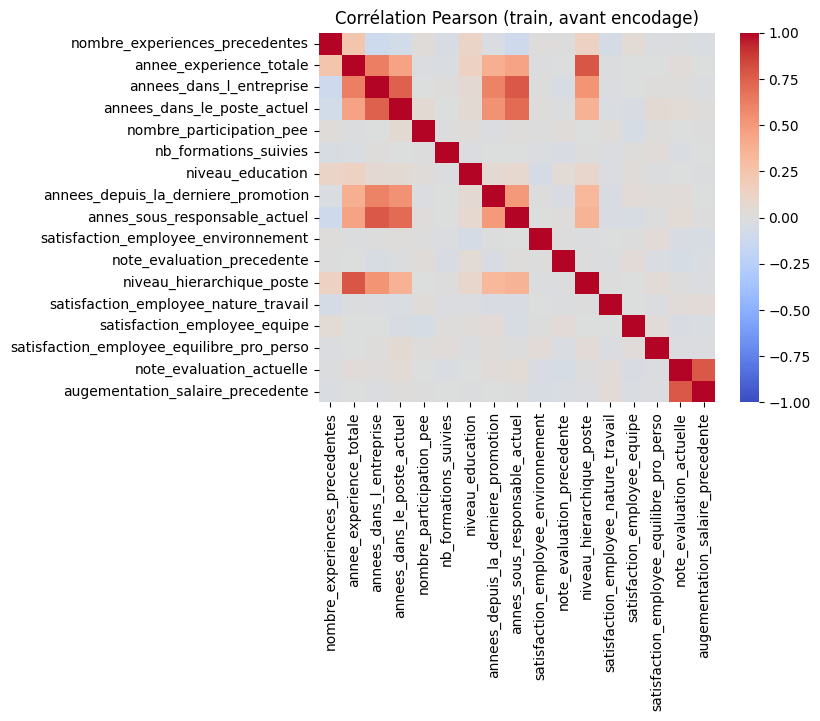

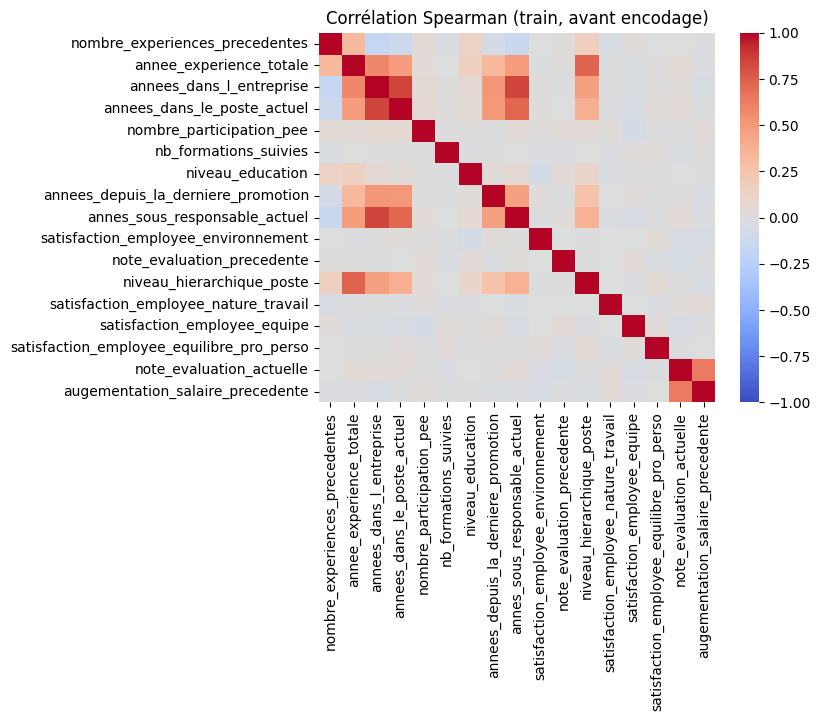

In [165]:
num_cols = X_train.select_dtypes(include='number').columns.tolist()

Xn = X_train[num_cols].copy()
Xn = Xn.fillna(Xn.median(numeric_only=True))

corr_p = Xn.corr(method='pearson')
corr_s = Xn.corr(method='spearman')

# Heatmap Pearson
sns.heatmap(corr_p, vmin=-1, vmax=1, cmap='coolwarm', center=0)
plt.title("Corrélation Pearson (train, avant encodage)")
plt.show()

# Heatmap Spearman
sns.heatmap(corr_s, vmin=-1, vmax=1, cmap='coolwarm', center=0)
plt.title("Corrélation Spearman (train, avant encodage)")
plt.show()

# Hypothèses

## 1. Faux négatif (employé qui va partir, mais prédit comme "reste")
    ### Problème pour les RH car perd une personne, sans l'anticiper

## 2. Faux positif (employé qui reste, mais prédit comme "quitte l’entreprise")
    ### Problème mais pour moi moins grave car on peut le mettre dans un sorte de flux de sortie mais annulé si pas le cas

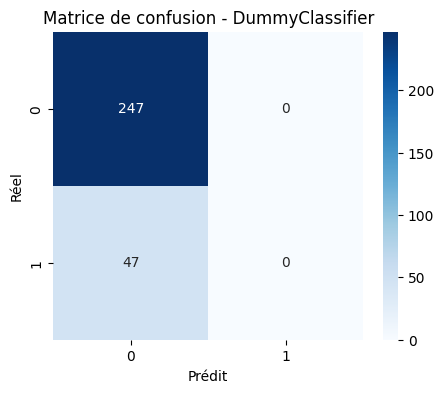

Rapport de classification - DummyClassifier :
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294

📊 Model: DummyClassifier
→ Accuracy: 0.839
→ Precision: 0.000
→ Recall: 0.000
→ F1-score: 0.000
→ Train Time: 7.60 ms
→ Predict Time: 6.88 ms


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no pre

In [166]:

model = DummyClassifier(strategy='most_frequent')

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', model)
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - DummyClassifier")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

print("Rapport de classification - DummyClassifier :")
print(classification_report(y_test, y_pred))
evaluate_classifier("DummyClassifier", pipe, X, y)


AUC-ROC = 0.5000


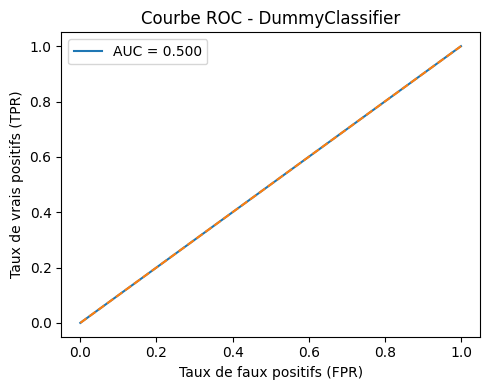

In [167]:

name = "DummyClassifier"

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC = {auc_roc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC - DummyClassifier")
plt.legend()
plt.tight_layout()
plt.show()

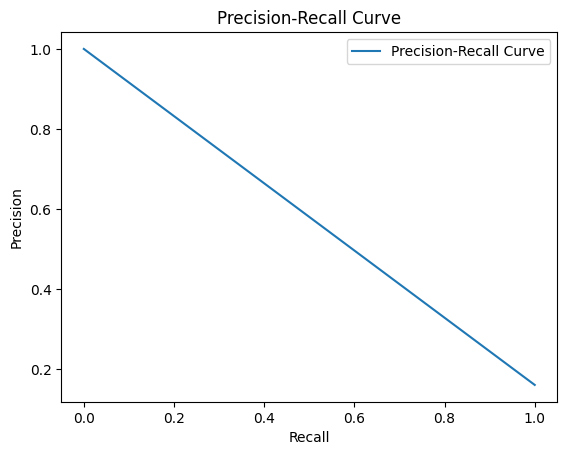

AUC-PR = 0.1599


In [168]:
# Courbe PR
precision_test, recall_test, thresholds_test = precision_recall_curve(
    y_test, y_pred_proba
)

plt.plot(recall_test, precision_test, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


auc_pr = average_precision_score(y_test, y_pred_proba)
print(f"AUC-PR = {auc_pr:.4f}")

results_auc.append({
    "Model": name,
    "AUC-ROC":  round(auc_roc, 3),
    "AUC-PR":  round(auc_pr, 3),
})

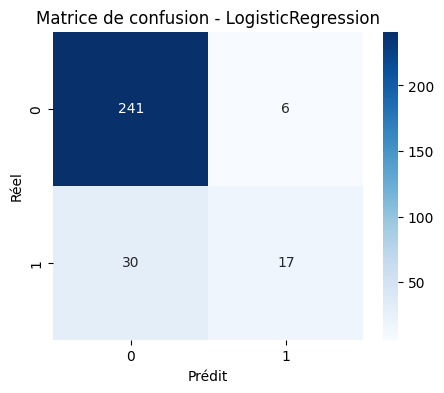

Rapport de classification - LogisticRegression
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       247
           1       0.74      0.36      0.49        47

    accuracy                           0.88       294
   macro avg       0.81      0.67      0.71       294
weighted avg       0.87      0.88      0.86       294

📊 Model: LogisticRegression
→ Accuracy: 0.891
→ Precision: 0.795
→ Recall: 0.439
→ F1-score: 0.565
→ Train Time: 802.36 ms
→ Predict Time: 15.15 ms


In [169]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model = LogisticRegression(max_iter=1000)

pipe = Pipeline([
    ('preprocessing', preprocessor),  
    ('classifier', model)            
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - LogisticRegression")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

print("Rapport de classification - LogisticRegression")
print(classification_report(y_test, y_pred))
evaluate_classifier("LogisticRegression", pipe, X, y)


AUC-ROC = 0.8480


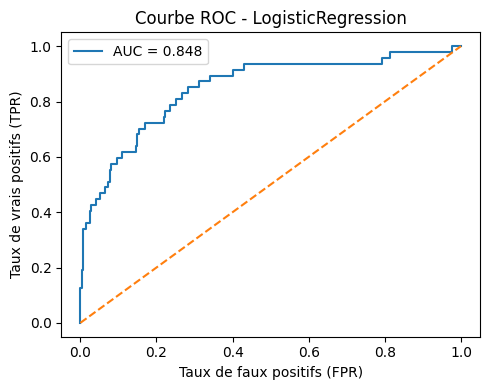

In [170]:
name = "LogisticRegression"

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC = {auc_roc:.4f}")

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC - LogisticRegression")
plt.legend()
plt.tight_layout()
plt.show()


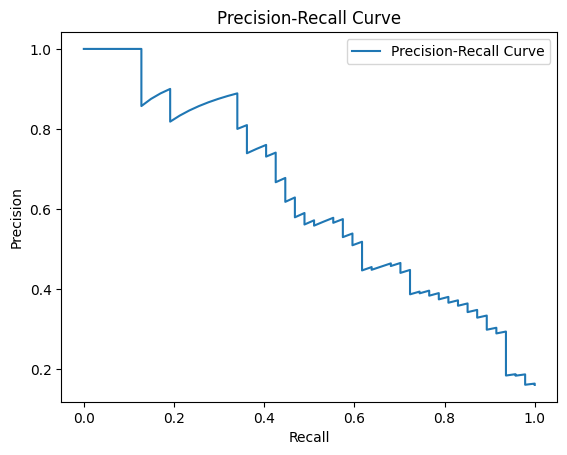

Average Precision (AUC-PR) = 0.6258


In [171]:
# Courbe PR
precision_test, recall_test, thresholds_test = precision_recall_curve(
    y_test, y_pred_proba
)

plt.plot(recall_test, precision_test, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


auc_pr = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision (AUC-PR) = {auc_pr:.4f}")


results_auc.append({
    "Model": name,
    "AUC-ROC":  round(auc_roc, 3),
    "AUC-PR":  round(auc_pr, 3),
})

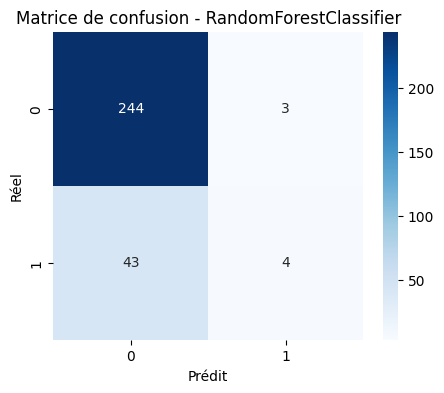

Rapport de classification - RandomForestClassifier
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       247
           1       0.57      0.09      0.15        47

    accuracy                           0.84       294
   macro avg       0.71      0.54      0.53       294
weighted avg       0.81      0.84      0.79       294

📊 Model: RandomForestClassifier
→ Accuracy: 0.857
→ Precision: 0.868
→ Recall: 0.143
→ F1-score: 0.240
→ Train Time: 132.58 ms
→ Predict Time: 11.69 ms


In [172]:
# RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model = RandomForestClassifier(random_state=42, class_weight='balanced')

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', model)            
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion - RandomForestClassifier")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

print("Rapport de classification - RandomForestClassifier")
print(classification_report(y_test, y_pred))
evaluate_classifier("RandomForestClassifier", pipe, X, y)


AUC-ROC = 0.7832


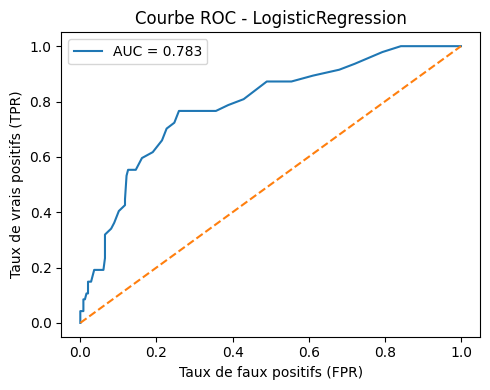

In [173]:
name = "RandomForestClassifier"

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC = {auc_roc:.4f}")

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC - LogisticRegression")
plt.legend()
plt.tight_layout()
plt.show()

# Courbe PR
precision_test, recall_test, thresholds_test = precision_recall_curve(
    y_test, y_pred_proba
)

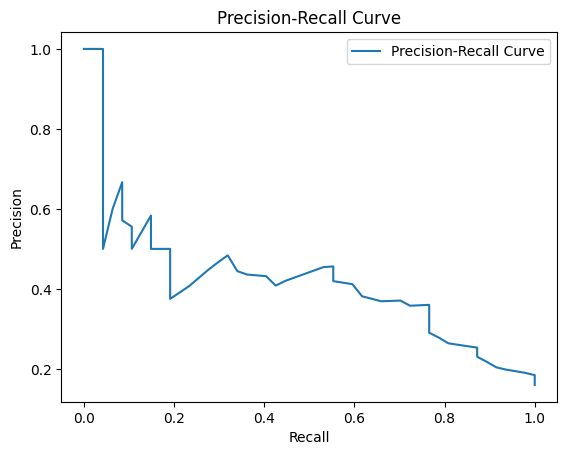

Average Precision (AUC-PR) = 0.4201


In [174]:
plt.plot(recall_test, precision_test, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


auc_pr = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision (AUC-PR) = {auc_pr:.4f}")

results_auc.append({
    "Model": name,
    "AUC-ROC":  round(auc_roc, 3),
    "AUC-PR":  round(auc_pr, 3),
})

In [175]:
df_results = pd.DataFrame(results)
display(df_results) 

,Model,Accuracy,Precision,Recall,F1,Train Time (ms),Predict Time (ms)
0,DummyClassifier,0.839,0.000,0.000,0.000,7.60,6.88
1,LogisticRegression,0.891,0.795,0.439,0.565,802.36,15.15
2,RandomForestClassifier,0.857,0.868,0.143,0.240,132.58,11.69


In [176]:
df_results_auc = pd.DataFrame(results_auc)
display(df_results_auc) 

,Model,AUC-ROC,AUC-PR
0,DummyClassifier,0.500,0.160
1,LogisticRegression,0.848,0.626
2,RandomForestClassifier,0.783,0.420




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



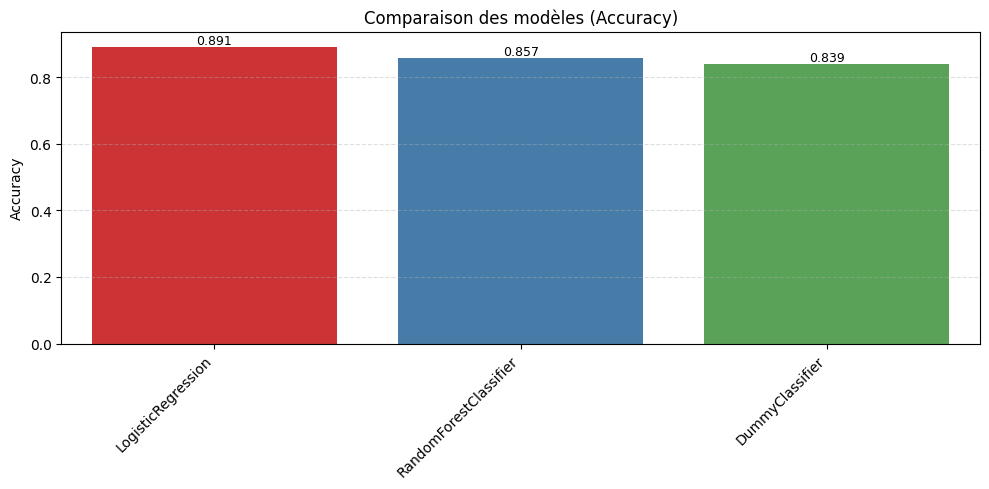

In [177]:
# Tri par meilleur Accuracy
df_sorted = df_results.sort_values("Accuracy", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_sorted, x="Model", y="Accuracy", palette="Set1")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}",           
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black', rotation=0)
    
# Comparaison Accuracy modèle
plt.title("Comparaison des modèles (Accuracy)")
plt.ylabel("Accuracy")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



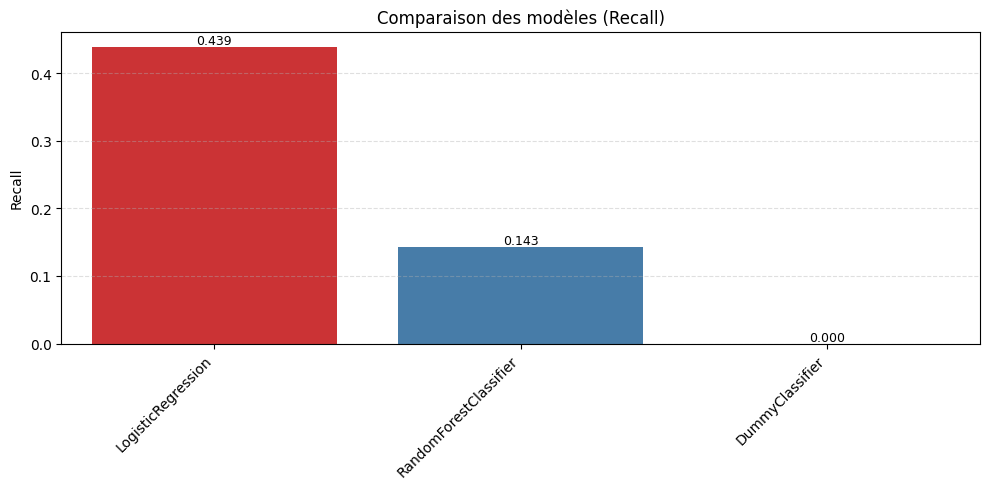

In [178]:
# Tri par meilleur Recall
df_sorted = df_results.sort_values("Recall", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_sorted, x="Model", y="Recall", palette="Set1")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}",           
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black', rotation=0)
    
# Comparaison Recall modèle
plt.title("Comparaison des modèles (Recall)")
plt.ylabel("Recall")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



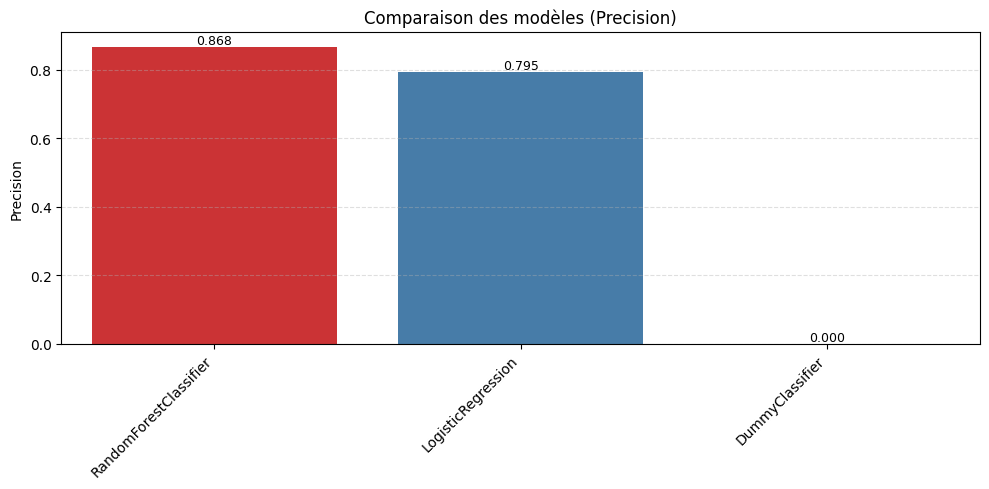

In [179]:
# Tri par meilleur Precision

df_sorted = df_results.sort_values("Precision", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_sorted, x="Model", y="Precision", palette="Set1")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}",           
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black', rotation=0)

plt.title("Comparaison des modèles (Precision)")
plt.ylabel("Precision")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



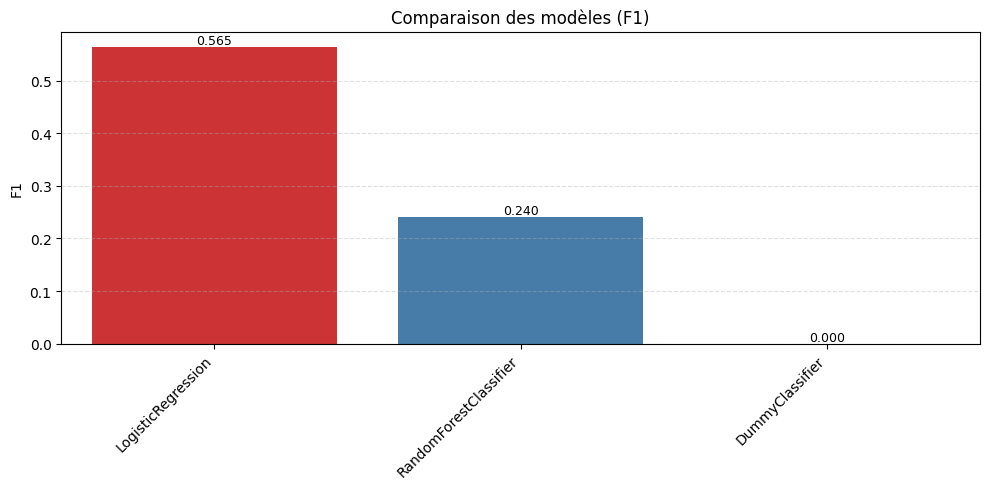

In [180]:
# Tri par meilleur F1
df_sorted = df_results.sort_values("F1", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_sorted, x="Model", y="F1", palette="Set1")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}",           
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black', rotation=0)
    
# Comparaison F1 modèle
plt.title("Comparaison des modèles (F1)")
plt.ylabel("F1")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



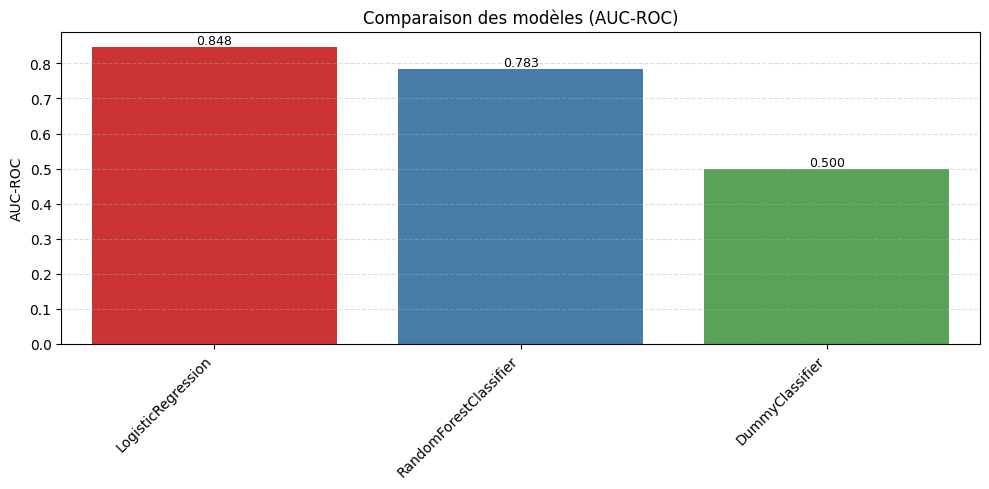

In [181]:
# Tri par meilleur AUC-ROC
df_sorted = df_results_auc.sort_values("AUC-ROC", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_sorted, x="Model", y="AUC-ROC", palette="Set1")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}",           
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black', rotation=0)

plt.title("Comparaison des modèles (AUC-ROC)")
plt.ylabel("AUC-ROC")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



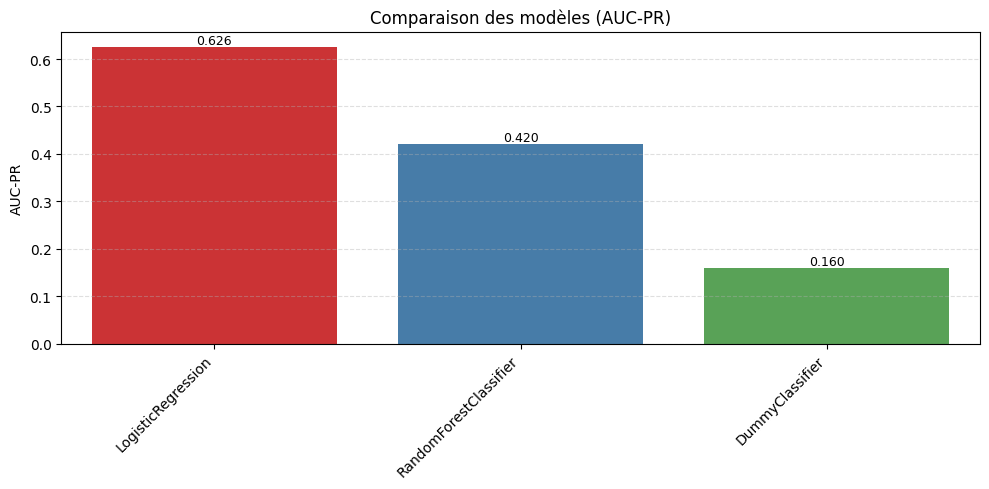

In [182]:
# Tri par meilleur AUC-PR
df_sorted = df_results_auc.sort_values("AUC-PR", ascending=False)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_sorted, x="Model", y="AUC-PR", palette="Set1")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}",           
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=9, color='black', rotation=0)

plt.title("Comparaison des modèles (AUC-PR)")
plt.ylabel("AUC-PR")
plt.xlabel("")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


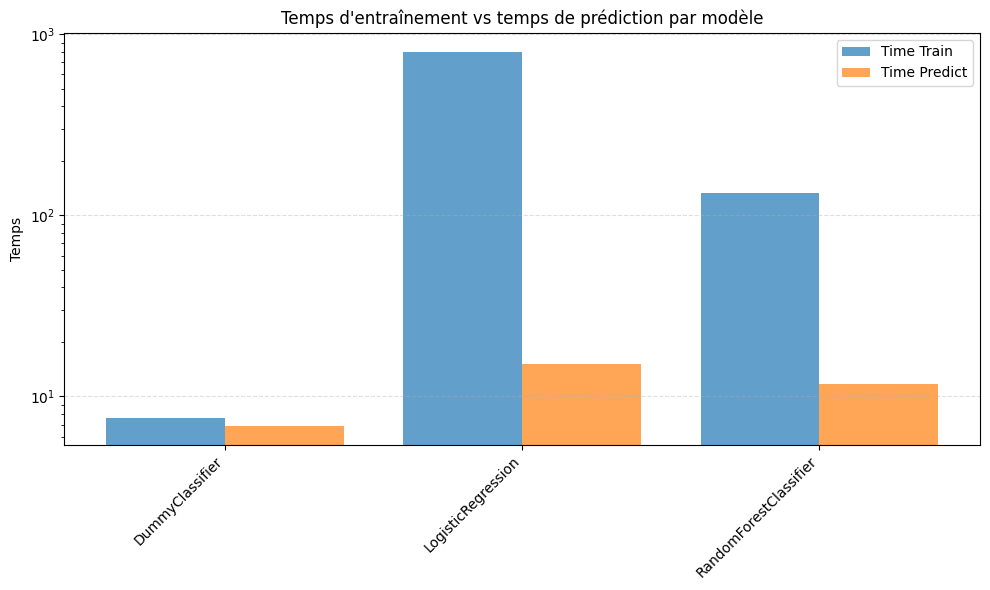

In [183]:
models = df_results["Model"].tolist()
time_train = df_results["Train Time (ms)"].tolist() 
time_predict = df_results["Predict Time (ms)"].tolist()

x = np.arange(len(models))
bar_width = 0.4

plt.figure(figsize=(10, 6))

plt.bar(x, time_train, width=bar_width, label='Time Train', alpha=0.7)
plt.bar(x + bar_width, time_predict, width=bar_width, label='Time Predict', alpha=0.7)

plt.xticks(x + bar_width / 2, models, rotation=45, ha='right')

plt.ylabel("Temps")
plt.title("Temps d'entraînement vs temps de prédiction par modèle")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.yscale('log')

plt.tight_layout()
plt.show()

### SMOTE 

In [184]:

model = LogisticRegression(max_iter=2000) 

pipe = Pipeline([
    ('preprocessing', preprocessor),               
    ('smote', SMOTE(random_state=42)),             
    ('classifier', model),
])

param_grid = {
    'smote__k_neighbors': [2, 3, 5],
    'smote__sampling_strategy': [0.5, 0.8, 1.0],
    'classifier__C': np.logspace(-3, 2, 6),      
    'classifier__class_weight': ['balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe, param_grid,
    scoring='f1_weighted',
    cv=cv, n_jobs=-1, refit=True, verbose=1
)

grid.fit(X_train, y_train.ravel())

print("Meilleur params:", grid.best_params_)
print("Meilleur CV score:", grid.best_score_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))


Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Meilleur params: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8}
Meilleur CV score: 0.8114161978653547
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       247
           1       0.44      0.74      0.55        47

    accuracy                           0.81       294
   macro avg       0.69      0.78      0.71       294
weighted avg       0.86      0.81      0.82       294



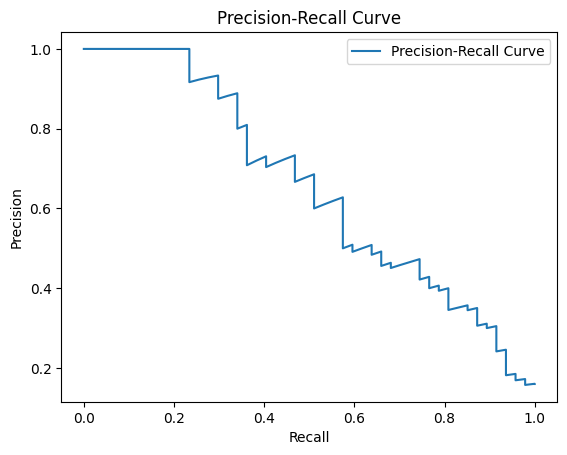

In [185]:
# Nom du modèle
name = "LogisticRegression + SMOTE (best params)"

y_pred_proba = grid.predict_proba(X_test)[:, 1]

precision_test, recall_test, thresholds_test = precision_recall_curve(
    y_test, y_pred_proba
)

plt.plot(recall_test, precision_test, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()



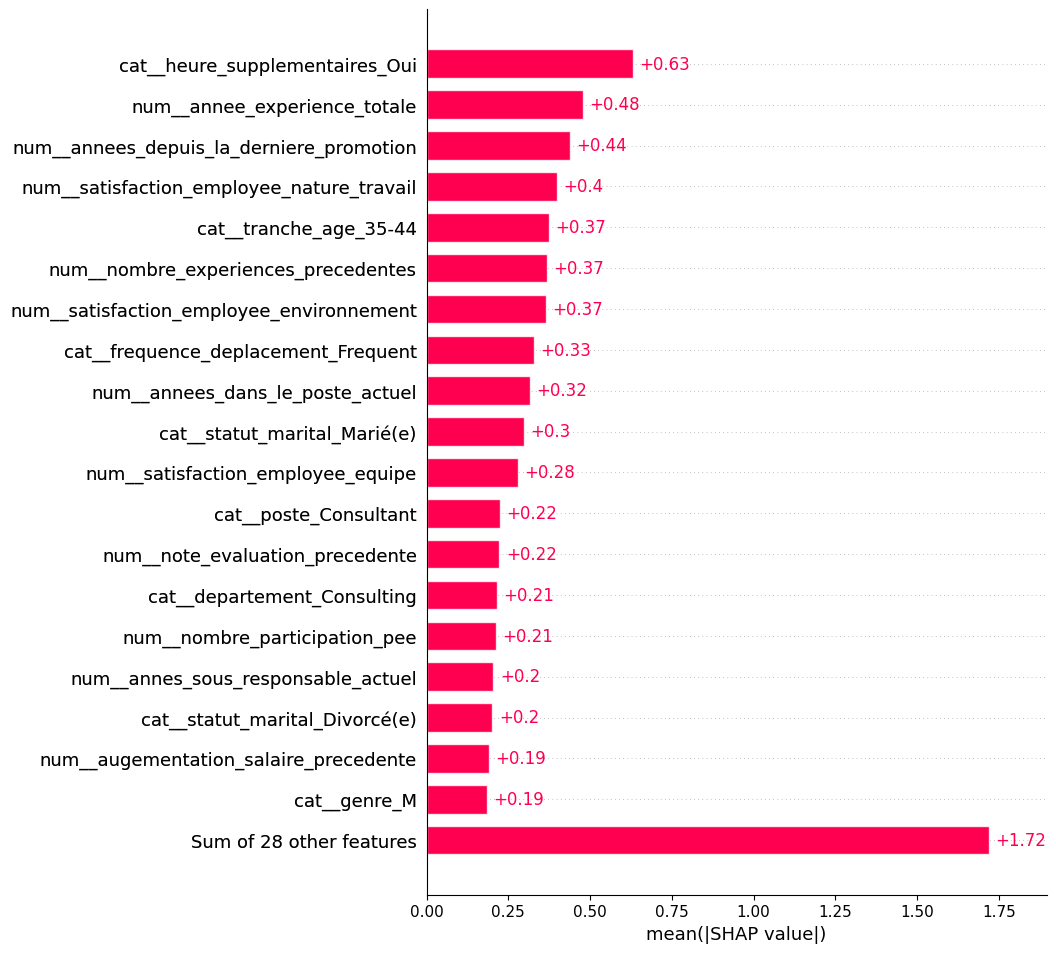

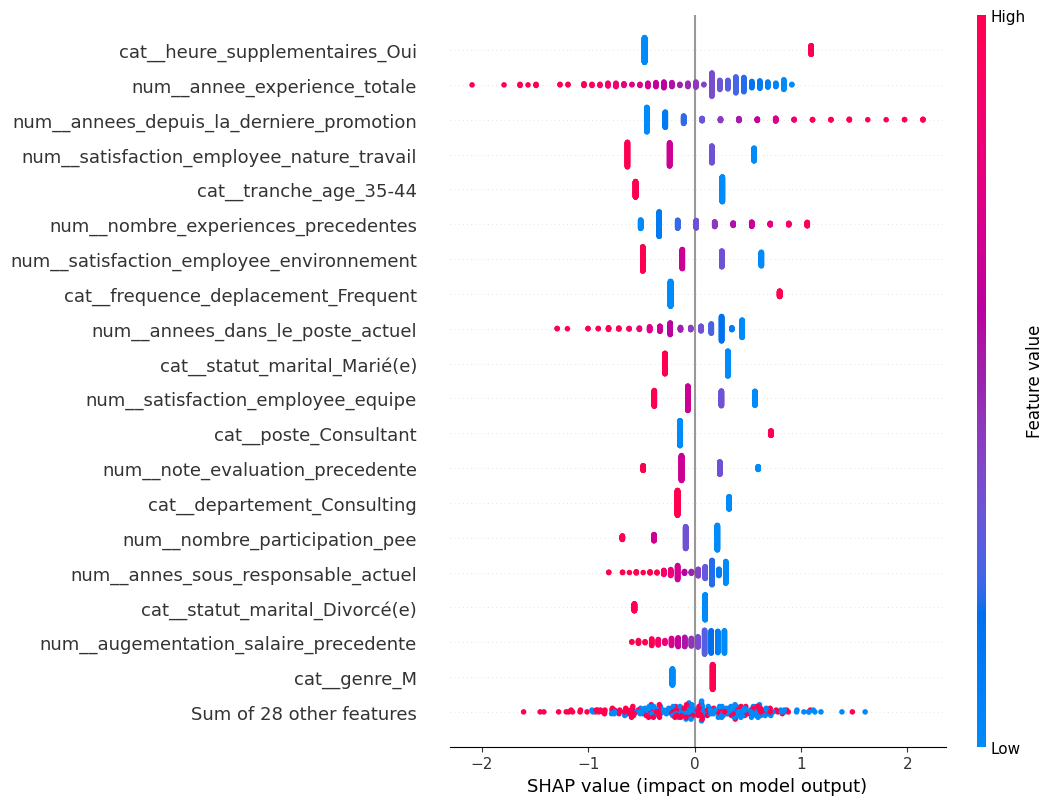

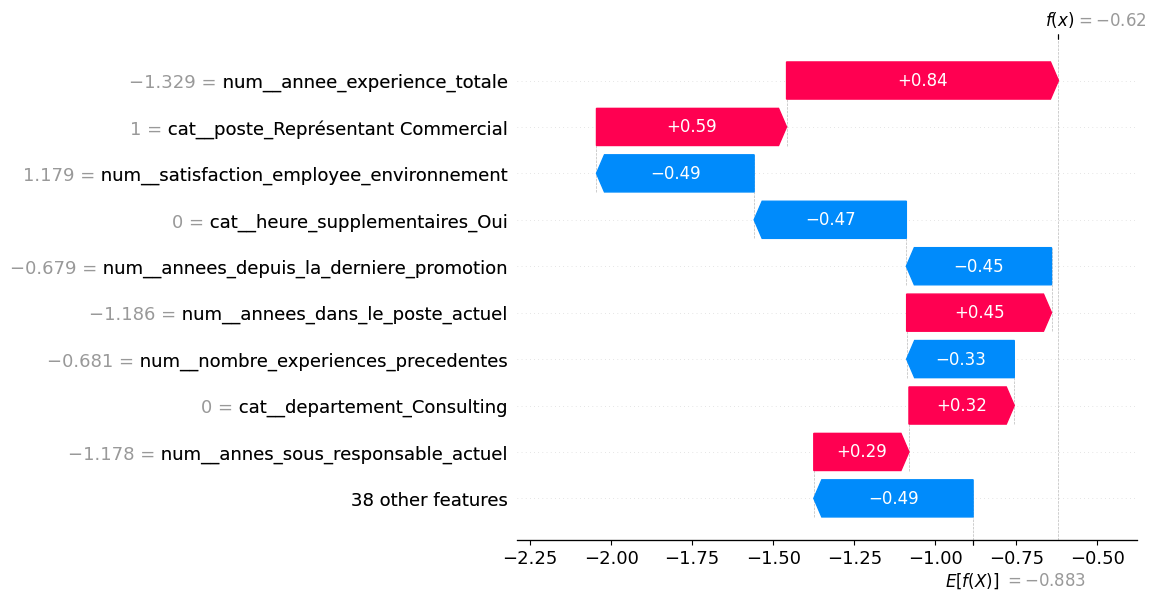

In [186]:
import shap
import pandas as pd
import numpy as np

best_pipe = grid.best_estimator_
pre  = best_pipe.named_steps['preprocessing']
clf  = best_pipe.named_steps['classifier']

Xtr = pre.transform(X_train)
Xte = pre.transform(X_test)
feat = pre.get_feature_names_out()

def to_df(X):
    return pd.DataFrame(X.toarray() if hasattr(X, "toarray") else X,
                        columns=feat)

Xtr_df, Xte_df = to_df(Xtr), to_df(Xte)

explainer = shap.LinearExplainer(clf, Xtr_df, link=shap.links.logit)
sv = explainer(Xte_df)   

mean_abs = pd.Series(
    np.abs(sv.values).mean(axis=0),
    index=feat
).sort_values(ascending=False)


shap.plots.bar(sv, max_display=20)      
shap.plots.beeswarm(sv, max_display=20) 

shap.plots.waterfall(sv[0], max_display=10)
